In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_line, geom_abline, annotate

## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [2]:
df = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")

In [3]:
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [4]:
X = df.drop(["diagnosis", "Name", "sex", "trtbps", "restecg", "thalach", "cp"], axis=1)
# y = (df["diagnosis"] == "Disease").astype(int)
y = df["diagnosis"]

In [5]:
logistic = LogisticRegression()
scaler = StandardScaler()

pipeline = Pipeline([
    ("logistic_regression", logistic)
]).set_output(transform = "pandas")

fitted_pipeline = pipeline.fit(X, y)

coefs = fitted_pipeline.named_steps["logistic_regression"].coef_[0]
log_intercept = fitted_pipeline.named_steps["logistic_regression"].intercept_[0]
columns = X.columns
columns = np.append(columns, "intercept")

log_coefs_df = pd.DataFrame({
    "Predictors" : columns,
    "Coefficients" : np.append(coefs, log_intercept)
})

log_coefs_df

,Predictors,Coefficients
0,age,0.046863
1,chol,0.001801
2,intercept,-3.240112


$$z_i = 0.047*\text{age}+0.001*\text{chol} - 3.24$$
$$z_i = log(\frac{p_i}{1-p_i}) = log(\frac{0.9}{1-0.9})$$

$$2.197 = 0.047 * 55 + 0.0018 * \text{chol} -3.24$$
$$2.197 - (0.047*55) = 0.0018 * \text{chol} -3.24$$

In [6]:
# 50% sure:
z_i = np.log(0.5/(1-0.5))
log_age_coef = log_coefs_df["Coefficients"][0]
log_chol_coef = log_coefs_df["Coefficients"][1]
round((z_i - (log_age_coef*55) - log_intercept) / log_chol_coef, 2)

367.87

In [7]:
# 90% sure:
z_i = np.log(0.9/(1-0.9))
round((z_i - (log_age_coef*55) - log_intercept) / log_chol_coef, 2)

1587.72

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [8]:
lda = LinearDiscriminantAnalysis()
scaler = StandardScaler()

pipeline = Pipeline([
    ("linear_discriminant_analysis", lda)
]).set_output(transform = "pandas")

fitted_pipeline = pipeline.fit(X, y)

coefs = fitted_pipeline.named_steps["linear_discriminant_analysis"].coef_[0]
lda_intercept = fitted_pipeline.named_steps["linear_discriminant_analysis"].intercept_[0]
columns = X.columns
columns = np.append(columns, "intercept")

lda_coefs_df = pd.DataFrame({
    "Predictors" : columns,
    "Coefficients" : np.append(coefs, lda_intercept)
})

lda_coefs_df

,Predictors,Coefficients
0,age,0.046557
1,chol,0.001790
2,intercept,-3.219678


In [9]:
# Cholesterol for heart disease present:
lda_age_coef = lda_coefs_df["Coefficients"][0]
lda_chol_coef = lda_coefs_df["Coefficients"][1]
round((0 - (lda_age_coef*55) - lda_intercept) / lda_chol_coef, 2)

368.24

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [10]:
svc = SVC(kernel="linear")

tune_df = {
    "support_vector_classifier__C": np.arange(0.5, 1, 0.01)
}

pipeline = Pipeline([
    ("support_vector_classifier", svc)
]).set_output(transform = "pandas")

grid_pipeline = GridSearchCV(pipeline, tune_df, cv=5, scoring="accuracy")
grid_results = grid_pipeline.fit(X, y)

search_dict_keys = [f"param_{item}" for item in tune_df.keys()]
search_dict_keys.append("mean_test_score")

grid_df = pd.DataFrame(grid_results.cv_results_)[search_dict_keys]
grid_df["mean_test_score"] = abs(grid_df["mean_test_score"])
grid_df = grid_df.sort_values(by=["mean_test_score"], ascending=False).head().reset_index(drop=True)
grid_df

,param_support_vector_classifier__C,mean_test_score
0,0.5,0.598293
1,0.87,0.598293
2,0.77,0.598293
3,0.78,0.598293
4,0.79,0.598293


In [11]:
svc = SVC(C=0.5, kernel="linear")

pipeline = Pipeline([
    ("support_vector_classifier", svc)
]).set_output(transform = "pandas")

fitted_pipeline = pipeline.fit(X, y)

coefs = fitted_pipeline.named_steps["support_vector_classifier"].coef_[0]
svc_intercept = fitted_pipeline.named_steps["support_vector_classifier"].intercept_[0]
columns = X.columns
columns = np.append(columns, "intercept")

svc_coefs_df = pd.DataFrame({
    "Predictors" : columns,
    "Coefficients" : np.append(coefs, svc_intercept)
})

svc_coefs_df

,Predictors,Coefficients
0,age,0.064427
1,chol,0.003650
2,intercept,-4.685061


In [12]:
# Cholesterol for heart disease present:
svc_age_coef = svc_coefs_df["Coefficients"][0]
svc_chol_coef = svc_coefs_df["Coefficients"][1]
round((0 - (svc_age_coef*55) - svc_intercept) / svc_chol_coef, 2)

312.72

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [13]:
age = np.arange(1, 101, 1)
age

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [14]:
# Generate x values
age = np.arange(0, 100, 1)

# Calculate y values based on the slope and intercept
y_log = (log_age_coef*age - log_intercept) / log_chol_coef
y_lda = (lda_age_coef*age - lda_intercept) / lda_chol_coef
y_svc = (svc_age_coef*age - svc_intercept) / svc_chol_coef

chol = np.append(y_log, y_lda)
chol = np.append(chol, y_svc)
labels = ["Logistic"] * 100 + ["LDA"] * 100 + ["SVM"] * 100

age2 = np.append(age, age)
age = np.append(age2, age)
# Create a dataframe for plotnine
chol_df = pd.DataFrame({
    "chol": chol,
    "labels": labels,
    "age": age
})

In [19]:
logstic_reg_line = geom_abline(intercept=-log_intercept/log_chol_coef, slope=-log_age_coef/log_chol_coef, color="black")
lda_line = geom_abline(intercept=-lda_intercept/lda_chol_coef, slope=-lda_age_coef/lda_chol_coef, color="green")
svc_line = geom_abline(intercept=-svc_intercept/svc_chol_coef, slope=-svc_age_coef/svc_chol_coef, color="orange")

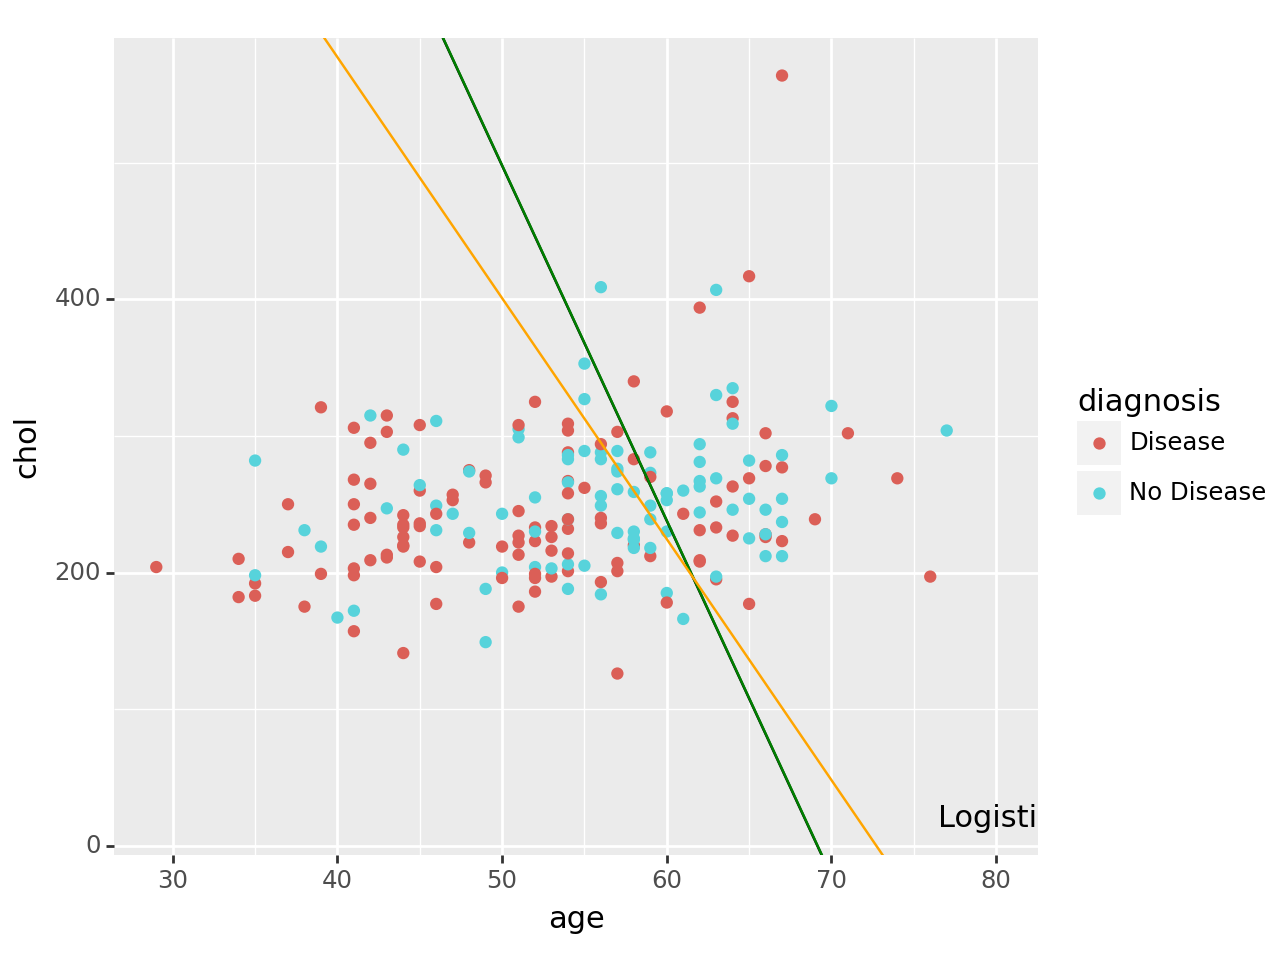

<Figure Size: (640 x 480)>

In [28]:
(ggplot(df, aes(x="age", y="chol", color="diagnosis"))
+ geom_point()
+ logstic_reg_line
+ lda_line
+ svc_line
+ annotate("text", x=80, y=20, label="Logistic", color="black"))